In [137]:
import shap
import torch
import torch as T
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import numpy as np
import pandas as pd
import sys
sys.path.append("../../../")
import D3QN

device = T.device("cuda:0" if T.cuda.is_available() else "cpu")
# Enable the plots in jupyter
shap.initjs()

def parse(func,size=100):
    X, Y = [], []
    feature_names = list(func()[0].keys())
    print(feature_names)
    for _ in range(size):
        x, y = func()
        X.append(list(x.values()))
        Y.append(y)
        #print(x, y)
    return X,Y,feature_names

def load_data(filepath,count=None):
    X,Y = [],[]
    df = pd.read_csv(filepath)
    for i in range(len(df)):
        obs = df.iloc[i, 0:-1].to_dict()
        label = df.iloc[i, -1]
        X.append(list(obs.values()))
        Y.append(label)
        feature_names = list(obs.keys())
    print(feature_names)
    if count is None:
        count = len(X)
    return X[:count],Y[:count],feature_names

In [138]:

class DuelingDeepQNetwork(nn.Module):
    def __init__(self, alpha, state_dim, action_dim, fc1_dim, fc2_dim):
        super(DuelingDeepQNetwork, self).__init__()

        self.fc1 = nn.Linear(state_dim, fc1_dim)
        self.fc2 = nn.Linear(fc1_dim, fc2_dim)
        self.V = nn.Linear(fc2_dim, 1)
        self.A = nn.Linear(fc2_dim, action_dim)

        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.to(device)

    def forward(self, state):
        x = T.relu(self.fc1(state))
        x = T.relu(self.fc2(x))

        V = self.V(x)
        A = self.A(x)
        Q = V + A - T.mean(A, dim=-1, keepdim=True)

        return Q

    def save(self, file_path):
        T.save(self, file_path)


# cache agent

In [139]:
class CacheAgentDataset():
    def cold_start(self):
        obs = {
            "es_load":random.uniform(0, 0.1),
            "free_storage_size_ratio_L1":random.uniform(0, 0.1),
            "free_storage_size_ratio_L2":random.uniform(0.9, 1),
            "free_storage_size_ratio_L3":random.uniform(0.9, 1),
            "can_L1_fit":1,
            "can_L2_fit":1,
            "can_L3_fit":1,
            "servie_size":random.uniform(5, 1000),
            "estimated_fetch_time":random.uniform(1, 60),
            "is_popular":0,
            "charm":round(abs(np.random.standard_normal(1)[0]), 2),
            "service_request_frequency":random.randint(0, 3),
            "nearby_servers_count":random.uniform(0, 1),
            "cached_in_nearby_servers":0,
            "es_request_frequency":random.uniform(0, 1)
        }
        return obs, "L1"

### IDLE

In [158]:
SAMPLE_SIZE = 100

model = torch.load('../../stages/final_1/cache_agent/0/D3QN_q_eval.pth')
torch.set_grad_enabled(True)
#func = CacheAgentDataset().cold_start
#X,Y,feature_names = parse(func)
X,Y,feature_names = load_data("./cache.csv",10)
#print(X,Y)

data = torch.tensor(X).float()
e = shap.DeepExplainer(model, data)
shap_values = e.shap_values(data)
expected_value = list(e.expected_value)
data = data.numpy()

['es_load', 'free_storage_size_ratio_L1', 'free_storage_size_ratio_L2', 'free_storage_size_ratio_L3', 'can_L1_fit', 'can_L2_fit', 'can_L3_fit', 'service_size', 'estimated_fetch_time', 'is_popular', 'charm', 'service_request_frequency', 'nearby_servers_count', 'cached_in_nearby_servers', 'es_request_frequency']


Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


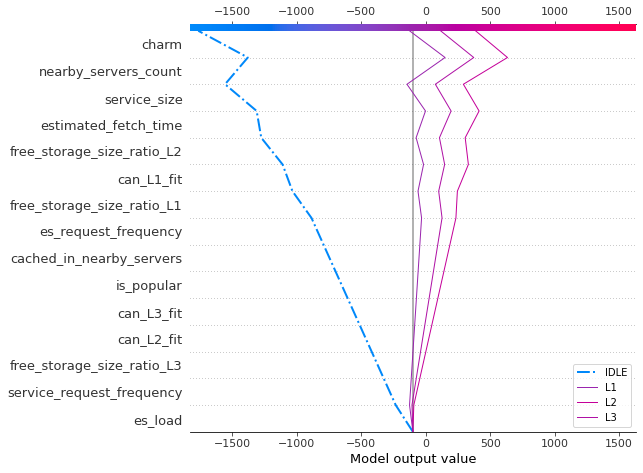

In [190]:
#'../../stages/final_2/cache_agent/0/D3QN_q_eval.pth' 4
#'../../stages/final_1/cache_agent/0/D3QN_q_eval.pth' 2
sample_index = 2

shap.multioutput_decision_plot(base_values=[-1500,100,600,400],
                               shap_values=shap_values,
                               row_index=sample_index,
                               feature_names=feature_names,
                               highlight=0,
                               legend_labels=["IDLE", "L1", "L2", "L3"],
                               legend_location='lower right')

(2, 100, 11)
(2, 11)


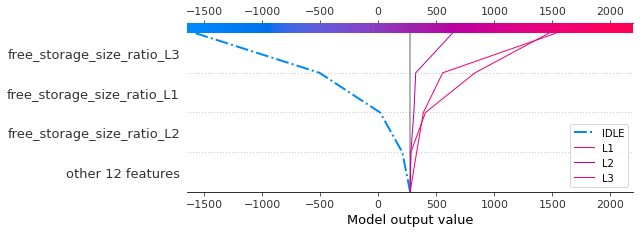

In [210]:
#'../../stages/final_2/cache_agent/0/D3QN_q_eval.pth' 4
#'../../stages/final_1/cache_agent/0/D3QN_q_eval.pth' 2
sample_index = 0
shap_values_ = np.array(shap_values)
print(shap_values_.shape)#(4, 10, 15)
print(shap_values_[:,sample_index,:].shape)#(4, 15)
feature_names_ = ["free_storage_size_ratio_L3","free_storage_size_ratio_L1","free_storage_size_ratio_L2","other 12 features"]
shap_values_=[[-1000,-453,-123,0],[630,420,120,0],[310,10,20,0],[920,110,2,0]]
shap_values_ = np.array(shap_values_)
shap_values_ = list(shap_values_[:,np.newaxis,:])


shap.multioutput_decision_plot(base_values=[-1000,300,300,500],
                               shap_values=shap_values_,
                               row_index=sample_index,
                               feature_names=feature_names_,
                               highlight=0,
                               legend_labels=["IDLE", "L1", "L2", "L3"],
                               legend_location='lower right')

# maintainance agent

In [142]:
# 生成的数据集
class MaintainanceDataset():
    def cold_start(self):
        loc = self.get_loc()
        obs = {
            "free_space_ratio":random.uniform(0.8, 1),
            "service_size_ratio":random.uniform(0, 0.1),
            "cached_in_L1": loc == "L1",
            "cached_in_L2": loc == "L2",
            "cached_in_L3": loc == "L3",
            "service_charm":random.randint(0, 5),
            "service_request_frequency":0,
            "es_request_frequency":random.uniform(0, 1),
            "es_cache_miss_rate":random.uniform(0.8, 1),
            "least_freq_index":random.randint(0, 2),
            "is_ugent":0
        }
        return obs, "PRESERVE"

### PRESERVE

In [198]:
model = torch.load('../../stages/final_2/maintainance_agent/2/D3QN_q_eval.pth')
torch.set_grad_enabled(True)
#func = MaintainanceDataset().cold_start
#X, Y ,feature_names = parse(func)
X,Y,feature_names = load_data("./maintainance.csv")

data = torch.tensor(X).float()
e = shap.DeepExplainer(model, data)
shap_values = e.shap_values(data)
expected_value = list(e.expected_value)
data = data.numpy()

['free_space_ratio', 'service_size_ratio', 'cached_in_L1', 'cached_in_L2', 'cached_in_L3', 'service_charm', 'service_request_frequency', 'es_request_frequency', 'es_cache_miss_rate', 'least_freq_index', 'is_ugent']


Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [199]:
'../stages/final_2/maintainance_agent/4/D3QN_q_eval.pth'
'../stages/final_2/maintainance_agent/3/D3QN_q_eval.pth'
'../stages/final_2/maintainance_agent/2/D3QN_q_eval.pth'
action_index = 0
base_value_ = expected_value[action_index]
shap_values_ = shap_values[action_index]

# 没找到合适的样本，先模拟一下
def gen_shap():
    t =  {
        'free_space_ratio':100 + random.uniform(-30,30),
        'service_size_ratio':random.uniform(-20,10),
        'cached_in_L1':random.uniform(-5,5),
        'cached_in_L2':random.uniform(-3,5),
        'cached_in_L3':random.uniform(-1,2),
        'service_charm':15 + random.uniform(-5,5),
        'service_request_frequency':random.uniform(-2,2),
        'es_request_frequency':random.uniform(-2,2),
        'es_cache_miss_rate':45 + random.uniform(-5,5),
        'least_freq_index':random.uniform(-1,1),
        'is_ugent':random.uniform(-1,1),
    }
    return list(t.values())


size = len(shap_values_)
shap_values_ = [gen_shap() for _ in range(size)]
shap_values_ = np.array(shap_values_)*10
base_value_ = 0

shap.force_plot(base_value=base_value_,
                shap_values=shap_values_,
                features=data,
                feature_names=feature_names)


### DELETE

In [145]:
'../stages/final_2/maintainance_agent/4/D3QN_q_eval.pth'
'../stages/final_3/maintainance_agent/4/D3QN_q_eval.pth'
'../stages/final_3/maintainance_agent/6/D3QN_q_eval.pth'
model = torch.load('../../stages/final_3/maintainance_agent/4/D3QN_q_eval.pth')
torch.set_grad_enabled(True)
#func = MaintainanceDataset().cold_start
#X, Y ,feature_names = parse(func)
X,Y,feature_names = load_data("./maintainance.csv")

data = torch.tensor(X).float()
e = shap.DeepExplainer(model, data)
shap_values = e.shap_values(data)
expected_value = list(e.expected_value)
data = data.numpy()

['free_space_ratio', 'service_size_ratio', 'cached_in_L1', 'cached_in_L2', 'cached_in_L3', 'service_charm', 'service_request_frequency', 'es_request_frequency', 'es_cache_miss_rate', 'least_freq_index', 'is_ugent']


Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [146]:
action_index = 1

base_value_= 0
shap_values_=shap_values[action_index] * -1

shap.force_plot(base_value=base_value_,
                shap_values=shap_values_,
                features=data,
                feature_names=feature_names)